In [1]:
# Some Jupyter notebook convenient functions
%load_ext autoreload
%autoreload 2
from welib.essentials import *

## Prerequisites
- The latest version of the python package `openfast_toolbox` needs to be installed and accessible by this notebook. 

- You can download and install it by following these steps:

```bash
git clone https://github.com/openfast/openfast_toolbox
cd openfast_toolbox
pip install -e . 
```

- If this is too advanced for you, you can place the folder `openfast_toolbox` provided with this package right next to this notebook. This way, the jupyter_notebook should be able to run directly.

    

In [2]:
### Load the openfast_toolbox and import the main class we will use `FFCaseCreation`
from openfast_toolbox.fastfarm.FASTFarmCaseCreation import FFCaseCreation, check_files_exist
from openfast_toolbox.tools.strings import OK

OK('The toolbox was successfully loaded!')

# 1 - Example 1: `Ex1_FASTFarm_discretization.py`

This example calculates the desired temporal and spatial resolution given a wind farm layout. 

The FAST.Farm guidelines requires several parameters to be set to find the resolutsion:
 - Spatial parameters: max chord (`cmax`), rotor diameter (`D`), meandering constant (`Cmeander`)
 - Temporal parameters: maximum excitation frequency (`fmax`), mean wind speed (`vhub`)
 - Model parameters: wake models (`mod_wake`), and background inflow type (`inflowType`)

Based on these parameters, the FFCaseCreation class can compute some default resolution, but it is often required to adjust some of them manually and not fully rely on the defaults.

In this example, we do the following:
- First, we obtain the default parameters and plot the layout
- Then, we manually adjust some of the resolution parameters




## 1.1 Parameters affecting the resolution

In [36]:
# -----------------------------------------------------------------------------
# --------------------------- Farm parameters ---------------------------------
# -----------------------------------------------------------------------------
# ----------- General turbine parameters
cmax     = 5      # Maximum blade chord (m)
fmax     = 10/6   # Maximum excitation frequency (Hz)
Cmeander = 1.9    # Meandering constant (-)
D = 240           # Rotor diameter (m)
zhub = 150        # Hub height (m)
# ----------- Wind farm
# The wts dictionary holds information of each wind turbine. The allowed entries
# are: x, y, z, D, zhub, cmax, fmax, Cmeander, and phi_deg. The phi_deg is the
# only entry that is optional and is related to floating platform heading angle,
# given in degrees. The angle phi_deg is not illustrated on the example below.
wts = {
    0 :{'x':  0.0, 'y':    0,  'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T1'},
    1 :{'x':  5*D, 'y':   D/2, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T2'},
}
# -----------------------------------------------------------------------------
# ------------------- Inflow conditions and input files -----------------------
# -----------------------------------------------------------------------------
# ----------- Additional variables
mod_wake = 2    # Wake model. 1: Polar, 2: Curled, 3: Cartesian. NOTE: Resolution guidelines vary based on this.
# ----------- Inflow parameters
inflowType = 'TS' # TS: TurbSim, or LES: LES (VTK files needs to exist)
# ----------- Desired sweeps of inflow conditions (here, only one value, no sweep)
vhub       = [8]  # NOTE: use the maximum velocity here [m/s]

## 1.2 Getting the default resolution and plotting the layout

In [38]:
# -----------------------------------------------------------------------------
# -------------------- FAST.Farm initial setup --------------------------------
# -----------------------------------------------------------------------------
# ----------- Initial setup
# Below we provide the minimal set of arguments needed to compute the resolution automatically.
ffcc = FFCaseCreation(wts=wts, vhub=vhub, 
                      mod_wake=mod_wake,
                      inflowType=inflowType)

       To do that, specify the values directly to `FFCaseCreation`, e.g.:
       `dt_high = 0.6`; `ds_high = 10.0`; `dt_low  = 1.8`; `ds_low  = 40.0`; 


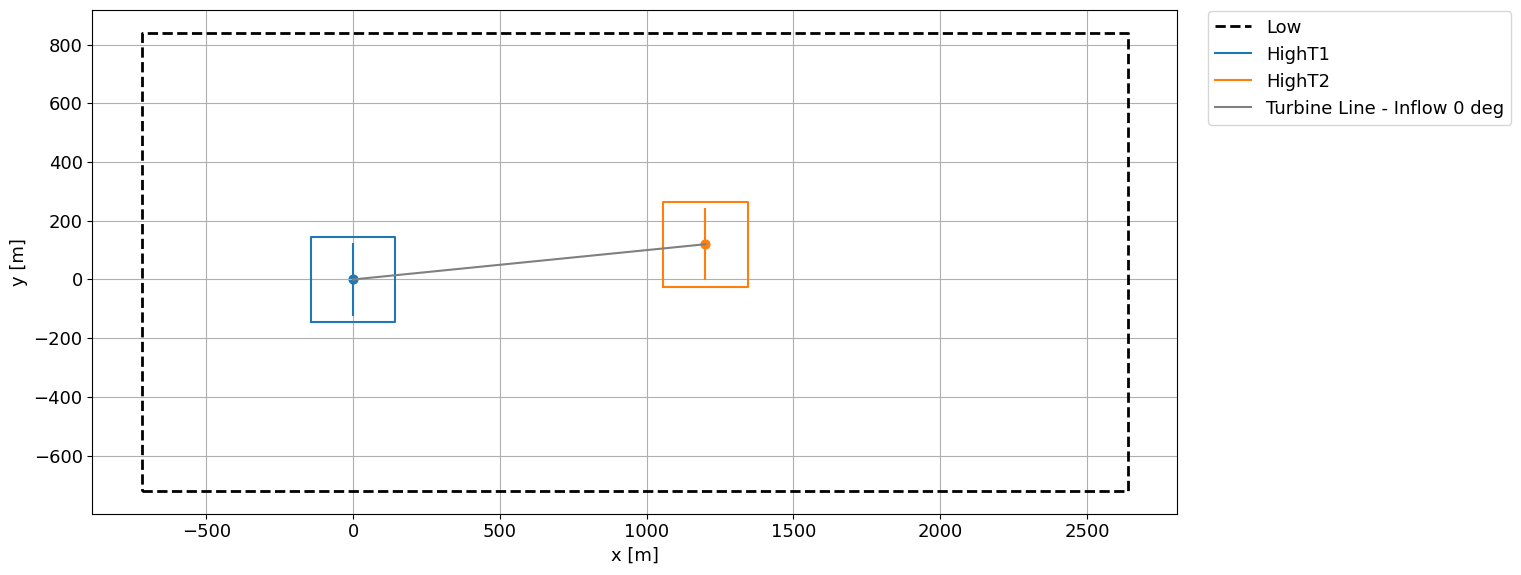

In [40]:
# Plot the FARM Layout
ffcc.plot()

The call to `FFCaseCreation` with no resolution expicitely provided (i.e., all the arguments `ds_low`, `dt_high` are set to  `None`) triggers the lengthy message above. From there, we can just check if those numbers make sense given the available computational resources. Highlight the warning printed with further instructions. Also, note that `dt_high=0.3` is a just a consequence of the value we selected for `fmax`, which isn't the actual maximum exitation frequency of the IEA 15MW. It is slightly more conservative than the (already conservative) 12P excitation frequency of about 1.5Hz. The reason we chose 10/6 is to get a round number for dt_high.

## 1.3 Adjusting the resolution

The output message above is saying that the low-res should be 24.32, but since it needs to be a multiple of the high res, then it automatically selects 20 m. However, since 24.32 is close to 25, we might want to just run at 25. Then, an option is to re-run the same command, but now passing a value for `ds_low`:

In [41]:
ds_low = 25 # user define low resolution [m]
# ----------- Initial setup (Now, with ds_low)
ffcc = FFCaseCreation(wts=wts, vhub=vhub, 
                      ds_low=ds_low,
                      mod_wake=mod_wake,
                      inflowType=inflowType, verbose=0)

       To do that, specify the values directly to `FFCaseCreation`, e.g.:
       `dt_high = 0.6`; `ds_high = 10.0`; `dt_low  = 1.8`; `ds_low  = 50`; 


Note how now the low-res grid resolution is set to 25 m. We can do the same with the dt if we want. Let's say we want the time steps of the low to be a more round number, we can set both dts:

In [42]:
dt_high = 0.25 # [s]
dt_low  = 1.00 # [s]
ds_low  = 25   # [m]
# ----------- Initial setup
ffcc = FFCaseCreation(wts=wts, vhub=vhub,
                     dt_high=dt_high,
                     dt_low=dt_low,   ds_low=ds_low,
                     mod_wake=mod_wake,
                     inflowType=inflowType)

       To do that, specify the values directly to `FFCaseCreation`, e.g.:
       `dt_high = 0.5`; `ds_high = 10.0`; `dt_low  = 2.0`; `ds_low  = 50`; 


This ends the illustration of the first example. Now we can move forward with the FAST.Farm setup using two options:

1. Use directly the `ffcc` object:
```
# ----------- Low- and high-res boxes parameters
# High-res boxes settings
dt_high     = ffcc.dt_high
ds_high     = ffcc.ds_high
extent_high = ffcc.extent_high
# Low-res boxes settings
dt_low      = ffcc.dt_low
ds_low      = ffcc.ds_low
extent_low  = ffcc.extent_low
```

2. Manually add those values to their corresponding variables:
```
# ----------- Low- and high-res boxes parameters
# High-res boxes settings
dt_high     =  0.25               
ds_high     =  5                 
extent_high =  1.2               
# Low-res boxes settings
dt_low      = 1.0                  
ds_low      = 25                 
extent_low  = [1.5,2.5,1.5,1.5,2]

```

In [43]:
# Note you can always print the object and get some information about the farm and the set of cases that will be setup:
print(ffcc)

<FFCaseCreation object> with the following content:
Requested parameters:
 - Case path: None
 - Wake model:              2 (1:Polar; 2:Curl; 3:Cartesian)
 - Number of TurbSim seeds: 1
 - End time:                1e-05 s
Requested farm:
 - Number of turbines:  2
 - Diameter:            240 m
 - Hub height:          150 m
 - Max chord:           5 m
 - Max excitation freq: 1.667 Hz
 - Meandering constant: 1.9
Requested sweeps:
 - Wind speeds at hub height (m/s): [8]
 - Shear exponent:                  [0]
 - TI (%):                          [10]
Case details:
 - Number of conditions: 1
 - Number of cases for each condition: 1
Turbulence boxes: TurbSim
TurbSim turbulence boxes details:
  Low-resolution domain: 
   - ds low: 1.0 m
   - dt low: 1.0 s
   - Extent of low-res box (in D): xmin = 3, xmax = 6, ymin = 3, ymax = 3, zmax = 2
   Low-res boxes created: False .
  High-resolution domain: 
   - ds high: 0.25 m
   - dt high: 0.25 s
   - Extent of high-res boxes: 1.2 D total
  High-res box

# Example 2: `Ex2a_FASTFarm_TurbSim_driven.py`

The example 2 for TurbSim has the same inputs as example 1 (the ones for the discretization), 
but additional inputs are now added to define the simulation setup. The new inputs are listed below:

- **General parameters**
    - `simPath` : folder (preferably new) where all the simulation files will be written
    -  `ffbin` and `tsbin`: location of the FAST.Farm and TurbSim executables
    - `templatePath`: existing folder, where the template FAST.Farm and OpenFAST files can be found.
    - `templateFiles`: location of files within templatePath to be used, or absolute location of required files.
        Note: some template files provided (like ED, SD, turbine fst) need to end with `.T` while  the actual filename inside `templatePath` is `*.T.<ext>` where `<ext>` is either `dat` or `fst`.

- **Farm parameters** (same as above)

- Inflow conditions and input files (same as above, but with more details):
   - `shear`, `TIvalue`, `inflow_deg`, together with `vhub` define the inflow values.
   - `tmax`: defines the maximum simulation time

- **Discretization parameters** (`dt_high`, `dt_low`, etc): these are the parameters we determined in Example 1.




### Pre-requisites to run the cells below:
 - A FAST.Farm Executable with version v4.*  (to be compatible with the input files provided)
 - A TurbSim Executable (any version>2 should do)
 - ROSCO libdiscon DLL or shared object with version 4.9

In [3]:
# -----------------------------------------------------------------------------
# ------------------------ General parameters ---------------------------------
# -----------------------------------------------------------------------------
simPath = 'ff_example_2a'            # folder (preferably new) where all the simulation files will be written
ffbin = './FAST.Farm_x64_v4.1.2.exe' # relative or absolute path of FAST.Farm executable
tsbin = './TurbSim_x64_v4.1.2.exe'   # relative or absolute path of TurbSim executable
templatePath = './template'
templateFiles = {
    'FFfilename'              : 'Main.fstf',
    'turbfilename'            : 'WT.T',
    "EDfilename"              : 'ED.T',
    'SrvDfilename'            : 'SvD.T',
    'ADfilename'              : 'AD.dat',
    'ADbladefilename'         : 'IEA-15-240-RWT_AeroDyn15_blade.dat',
    'IWfilename'              : 'IW_WT.dat',
    'EDbladefilename'         : 'IEA-15-240-RWT_ElastoDyn_blade.dat',
    'EDtowerfilename'         : 'IEA-15-240-RWT-Monopile_ElastoDyn_tower.dat',
    'controllerInputfilename' : 'DISCON_ROSCOv2.9.IN',
    'libdisconfilepath'       : './template/libdiscon_rosco_v2.9.0.dll',
    'turbsimLowfilepath'      : './SampleFiles/template_Low_InflowXX_SeedY.inp',
    'turbsimHighfilepath'     : './SampleFiles/template_HighT1_InflowXX_SeedY.inp'
}
check_files_exist(ffbin, tsbin, templatePath)

In [4]:
# -----------------------------------------------------------------------------
# --------------------------- Farm parameters ---------------------------------
# -----------------------------------------------------------------------------
# ----------- General turbine parameters
cmax     = 5      # Maximum blade chord (m)
fmax     = 10/6   # Maximum excitation frequency (Hz)
Cmeander = 1.9    # Meandering constant (-)
D = 240           # Rotor diameter (m)
zhub = 150        # Hub height (m)
# ----------- Wind farm
# The wts dictionary holds information of each wind turbine. The allowed entries
# are: x, y, z, D, zhub, cmax, fmax, Cmeander, and phi_deg. The phi_deg is the
# only entry that is optional and is related to floating platform heading angle,
# given in degrees. The angle phi_deg is not illustrated on the example below.
wts = {
    0 :{'x':  0.0, 'y':    0,  'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T1'},
    1 :{'x':  5*D, 'y':   D/2, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T2'},
}

In [51]:
# -----------------------------------------------------------------------------
# ------------------- Inflow conditions and input files -----------------------
# -----------------------------------------------------------------------------
# ----------- Additional variables
tmax = 50       # Total simulation time
zbot = 1        # Bottom of your domain
mod_wake = 2    # Wake model. 1: Polar, 2: Curled, 3: Cartesian
# ----------- Inflow parameters
inflowType = 'TS'
# ----------- Desired sweeps
vhub       = [8]    #
shear      = [0.1]
TIvalue    = [10]
inflow_deg = [0]

In [ ]:
# -----------------------------------------------------------------------------
# ---------------------- Discretization parameters ----------------------------
# -----------------------------------------------------------------------------
# ----------- Low- and high-res boxes parameters
# High-res boxes settings
dt_high     =  0.25               # sampling time of high-res files [s]
ds_high     =  5                  # dx, dy, dz of high-res files [m]
extent_high =  1.2                # extent in y and x for each turbine, in D
# Low-res boxes settings
dt_low      = 1.0                 # sampling time of low-res files [s]
ds_low      = 25                  # dx, dy, dz of low-res files [m]
extent_low  = [1.5,2.5,1.5,1.5,2] # extent in [xmin,xmax,ymin,ymax,zmax], in D

In [45]:
# -----------------------------------------------------------------------------
# -------------------- FAST.Farm initial setup --------------------------------
# -----------------------------------------------------------------------------
# ----------- Initial setup
os.chdir(notepath)
ffcase = FFCaseCreation(path, wts, tmax, zbot, vhub, shear, TIvalue, inflow_deg,
                        dt_high=dt_high, ds_high=ds_high, extent_high=extent_high,
                        dt_low=dt_low,   ds_low=ds_low,   extent_low=extent_low,
                        ffbin=ffbin, mod_wake=mod_wake,
                        nSeeds=nSeeds, tsbin=tsbin, inflowType=inflowType,
                        refTurb_rot=refTurb_rot, verbose=1)

# ----------- Perform auxiliary steps in preparing the case
ffcase.setTemplateFilename(templatePath, templateFiles)
ffcase.getDomainParameters()
ffcase.copyTurbineFilesForEachCase()

SyntaxError: invalid syntax (3810621900.py, line 9)

There are a few things the user can look at to check the setup. One of them, as mentioned is to print the object. Others are to print the datasets that hold the information for all the cases:

In [5]:
ffcase.allCases


<xarray.Dataset> Size: 217B
Dimensions:          (case: 1, turbine: 2)
Coordinates:
  * case             (case) int64 8B 0
  * turbine          (turbine) int64 16B 0 1
Data variables: (12/15)
    Tx               (case, turbine) float64 16B 500.0 1.1e+03
    Ty               (case, turbine) float64 16B 480.0 480.0
    Tz               (case, turbine) float64 16B 0.0 0.0
    phi              (case, turbine) float64 16B 0.0 0.0
    D                (case, turbine) int64 16B 240 240
    zhub             (case, turbine) int64 16B 150 150
    ...               ...
    EDmodel          (case, turbine) object 16B 'FED' 'FED'
    ADmodel          (case, turbine) object 16B 'ADyn' 'ADyn'
    nFulllElastoDyn  (case) int64 8B 2
    nFullAeroDyn     (case) int64 8B 2
    yawmis           (case, turbine) float64 16B 0.0 0.0
    misalignment     (case) bool 1B False

You have easy access to information related to your case. This FAST.Farm setup is for a single condition with a single case, so this array is simple. Will show later more complex cases and how to pick out information from the array above.

You can also plot your setup. On the plot, the extents set previously become clear. See how the `extent_low` related to xmax is larger than the others.

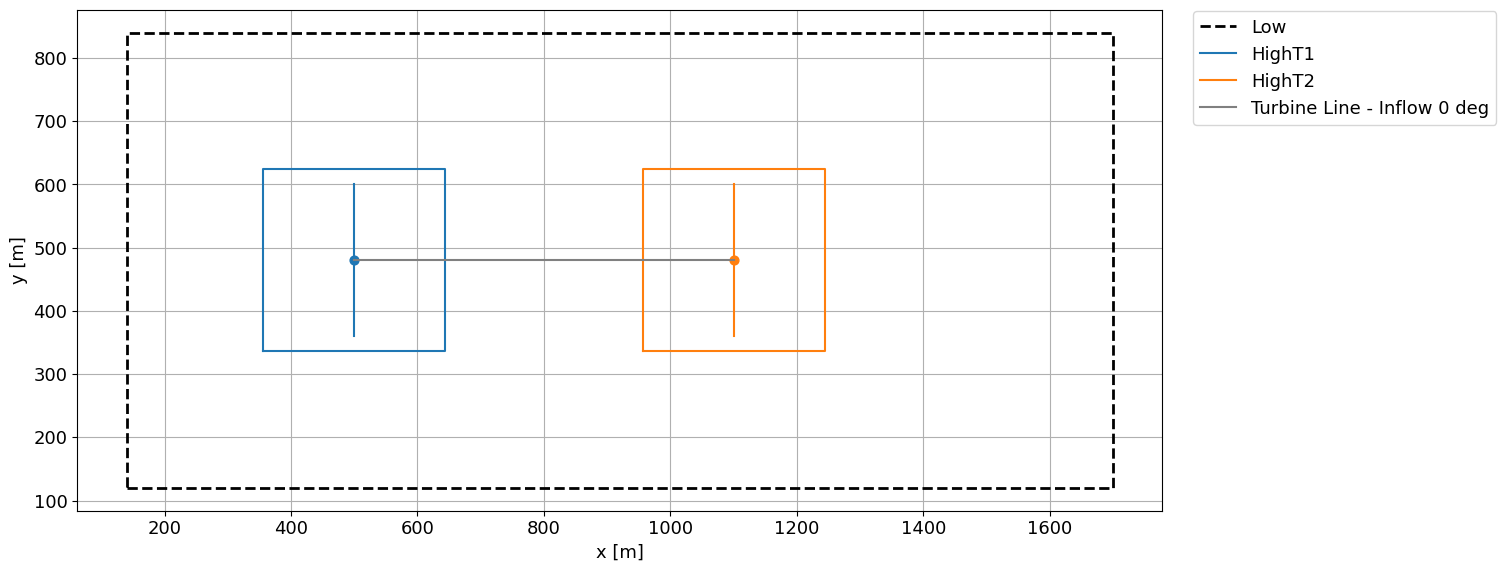

In [6]:
ffcase.plot()  # add showTurbNumber=True to help with potential debugging
# The plot command above saves the images to the case root `ffcase.path`

Now comes the main part, which is the turbsim setup. The third call is commented out since you won't be doing this from an HPC.

In [7]:
# -----------------------------------------------------------------------------
# ---------------------- TurbSim setup and execution --------------------------
# -----------------------------------------------------------------------------
# ----------- TurbSim low-res setup
ffcase.TS_low_setup()
# ----------- Prepare script for submission
ffcase.TS_low_slurm_prepare(slurm_TS_low)
# ----------- Submit the low-res script (can be done from the command line)
#ffcase.TS_low_slurm_submit()

FileNotFoundError: [Errno 2] No such file or directory: 'ff_example2a\\Cond00_v08.0_PL0.1_TI10\\Seed_0\\Low_stillToBeModified.inp'

Now, if you go the the directory of this case, `ffcase.path`, you will see a _condition_ directory, the png of the farm above, and a bash script to be submitted to slurm. You can submit it through the command line or you can use the `ffcase.TS_low_slurm_submit()` above. You should open the script and show people what it is doing. Some stuff there (like modules) is given for Kestrel. For someone to use it on their own HPC system, they just need to create new template versions of those and give as inputs through the `slurm_TS_high`, `slurm_TS_low`, and `slurm_FF_single` variables.

In [ ]:
 # For the sake of illustration here, I'll submit it. Note this calls takes a few key SLURM parameters. (takes about 10s)
ffcase.TS_low_slurm_submit(A='shellwind', qos='high', t='0:10:00', p='debug')

Now with the low-res completed, we can move forward with the high-res. Note that if you try to call `ffcase.TS_high_setup()` before the low-res is done, it will stop when trying to open the low-res box.

In [ ]:
# ----------- TurbSim high-res setup
ffcase.TS_high_setup()
# ----------- Prepare script for submission
ffcase.TS_high_slurm_prepare(slurm_TS_high)
# ----------- Submit the high-res script (can be done from the command line)
#ffcase.TS_high_slurm_submit()

The calls above create the time series to drive the high-res box, taking into account where the turbines are, inclusing the `offset` parameter to TurbSim and also the rolling of the time series, considering how downstream each turbine is.

In [ ]:
# Let's run the turbsim boxes. Takes about 3min at the 0.25s temporal res
ffcase.TS_high_slurm_submit(A='shellwind', qos='high', t='0:06:00', p='debug')

After this runs, we can move forward with the FAST.Farm setup. Note how the wake model parameters can be easily set.

In [ ]:
# -----------------------------------------------------------------------------
# ------------------ Finish FAST.Farm setup and execution ---------------------
# -----------------------------------------------------------------------------
# ----------- FAST.Farm setup
ffcase.FF_setup()
# Update wake model constants (adjust as needed for your turbine model)
ffcase.set_wake_model_params(k_VortexDecay=0, k_vCurl=2.8)

# ----------- Prepare script for submission
ffcase.FF_slurm_prepare(slurm_FF_single)

# ----------- Submit the FAST.Farm script (can be done from the command line)
#ffcase.FF_slurm_submit(p='debug', t='1:00:00')

In [ ]:
# Modify the time step and UA model for this specific case. This also illustrates how to change variables
import os
from openfast_toolbox.fastfarm.FASTFarmCaseCreation import modifyProperty

for cond in range(ffcase.nConditions):
    for case in range(ffcase.nCases):
        ad_file  = os.path.join(ffcase.path, ffcase.condDirList[cond], ffcase.caseDirList[case], ffcase.ADfilename)
        modifyProperty(ad_file, 'UA_Mod', 4)
        modifyProperty(ad_file, 'SectAvg', False)
        for turb in range(ffcase.nTurbines):
            fst_file = os.path.join(ffcase.path, ffcase.condDirList[cond], ffcase.caseDirList[case], f'{ffcase.turbfilename}{turb+1}.fst')
            modifyProperty(fst_file, 'DT', 0.001)
            

Let's add some sampling planes so we can process them later.

In [ ]:
# ----------- Wake planes to be saved for each turbine (only 9 planes at most can be saved)
# The offset is useful if we start sampling at 0 D, so that we actually have an usable plane that is not _at_ the hub plane.
wakeplanes_in_D = [1.5, 2.0] # remember the extent on this case is 2.5D
offset = 0
# Wake points (not planes). Can have up to 9 per turbine
wakepoints_in_D = [1,2]


# Add wake plane saving (the hub-height and vertical thought the centerline planes are already properly configured though `FF_setup()`
for cond in range(ffcase.nConditions):
    for case in range(ffcase.nCases):
        for seed in range(ffcase.nSeeds):
            ff_file = os.path.join(ffcase.path, ffcase.condDirList[cond], ffcase.caseDirList[case], f'Seed_{seed}', ffcase.outputFFfilename)
            modifyProperty(ff_file, 'WrDisWind', True)
            # Parameters for the wake locations
            Tx = ffcase.allCases.isel(case=case).Tx.values
            # Wake plane (yz plane)
            outdistYZ = np.array([[w*ffcase.D for w in wakeplanes_in_D]+tx+offset for tx in Tx]).flatten()
            outdiststrYZ = ', '.join(map(str, outdistYZ))
            modifyProperty(ff_file, 'NOutDisWindYZ', len(outdistYZ))
            modifyProperty(ff_file, 'OutDisWindX', outdiststrYZ)
            # Wake (repeated for every turbine within FAST.Farm)
            outdist = np.array([w*ffcase.D+offset for w in wakepoints_in_D]).flatten()
            outdiststr = ', '.join(map(str, outdist))
            modifyProperty(ff_file, 'NOutDist', len(outdist))
            modifyProperty(ff_file, 'OutDist', outdiststr)
            # Let's change the frequency planes are saved (default is dt_low)
            modifyProperty(ff_file, 'WrDisDT', 1)


In [ ]:
# We have 6 seeds, so 6 cases. This call will submit each one of them separately. Should take ~5min each.
ffcase.FF_slurm_submit(A='shellwind', qos='high', t='1:00:00')

In [ ]:
# We can finally just dump the object to disk so we can re-open another time or for post-processing. It will be saved on the ffcase.path path
ffcase.save()

This concludes the second example. If the input files were valid (meaning they would not result in a fatal error using OpenFAST), the FAST.Farm simulation would likely be successful here.

# 3. More complex setups

# 3.1 Wind speed and wind dir sweep

Let's now try to sweep in some wind speeds and directions.

In [ ]:
# -----------------------------------------------------------------------------
# USER INPUT: Modify these
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# ------------------------ General parameters ---------------------------------
# -----------------------------------------------------------------------------

# ----------- Case absolute path
path = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/ff_examples_ex2a_widr'

# ----------- Execution parameters
# If you are sure the correct binaries are first on your $PATH and associated
# libraries on $LD_LIBRARY_PATH, you can set the variables below to None or
# remove them from the `FFCaseCreation` call
ffbin = '/projects/tcwnd/rthedin/repos/openfast_v4.1.1/build/install/bin/FAST.Farm'
tsbin = '/projects/tcwnd/rthedin/repos/openfast_v4.1.1/build/install/bin/turbsim'


# -----------------------------------------------------------------------------
# --------------------------- Farm parameters ---------------------------------
# -----------------------------------------------------------------------------

# ----------- General turbine parameters
cmax     = 5      # Maximum blade chord (m)
fmax     = 10/6   # Maximum excitation frequency (Hz)
Cmeander = 1.9    # Meandering constant (-)
D = 240           # Rotor diameter (m)
zhub = 150        # Hub height (m)

# ----------- Wind farm
# The wts dictionary holds information of each wind turbine. The allowed entries
# are: x, y, z, D, zhub, cmax, fmax, Cmeander, and phi_deg. The phi_deg is the
# only entry that is optional and is related to floating platform heading angle,
# given in degrees. The angle phi_deg is not illustrated on the example below.
wts = {
    0 :{'x': 500.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T1'},
    1 :{'x':1100.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T2'},
    2 :{'x':1800.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T3'},
    3 :{'x': 500.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T4'},
    4 :{'x':1100.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T5'},
    5 :{'x':1800.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T6'},
}
refTurb_rot = 0

# ----------- Turbine parameters
# Set the yaw of each turbine for wind dir. One row for each wind direction.
yaw_init = None


# -----------------------------------------------------------------------------
# ------------------- Inflow conditions and input files -----------------------
# -----------------------------------------------------------------------------

# ----------- Additional variables
tmax = 100      # Total simulation time
nSeeds = 6      # Number of seeds
zbot = 1        # Bottom of your domain
mod_wake = 2    # Wake model. 1: Polar, 2: Curled, 3: Cartesian

# ----------- Inflow parameters
inflowType = 'TS'

# ----------- Desired sweeps
vhub       = [8, 10]
shear      = [0.1]
TIvalue    = [10]
inflow_deg = [-5, 0, 5]


# ----------- Template files
templatePath = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/tutorial_files'
# Files should be in templatePath. Put None on any input that is not applicable.
templateFiles = {
    "EDfilename"              : 'IEA-15-240-RWT-Monopile_ElastoDyn.T',
    'SrvDfilename'            : 'IEA-15-240-RWT-Monopile_ServoDyn.T',
    'ADfilename'              : 'IEA-15-240-RWT-Monopile_AeroDyn15.dat',
    'ADbladefilename'         : 'IEA-15-240-RWT_AeroDyn15_blade.dat',
    'IWfilename'              : 'IW_WT.dat',
    'EDbladefilename'         : 'IEA-15-240-RWT_ElastoDyn_blade.dat',
    'EDtowerfilename'         : 'IEA-15-240-RWT-Monopile_ElastoDyn_tower.dat',
    'turbfilename'            : 'IEA-15-240-RWT-Monopile.T',
    'libdisconfilepath'       : '/projects/tcwnd/rthedin/repos/ROSCO_v2.9.5/rosco/controller/build/libdiscon.so',
    'controllerInputfilename' : 'IEA-15-240-RWT-Monopile_DISCON_ROSCOv2.9.IN',
    'FFfilename'              : 'FAST.Farm.fstf',
    'turbsimLowfilepath'      : '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/template_Low_InflowXX_SeedY.inp',
    'turbsimHighfilepath'     : '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/template_HighT1_InflowXX_SeedY.inp'
}
# SLURM scripts
slurm_TS_high           = '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/runAllHighBox.sh'
slurm_TS_low            = '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/runAllLowBox.sh'
slurm_FF_single         = '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/runFASTFarm_cond0_case0_seed0.sh'


# -----------------------------------------------------------------------------
# ---------------------- Discretization parameters ----------------------------
# -----------------------------------------------------------------------------
# ----------- Low- and high-res boxes parameters
# High-res boxes settings
dt_high     =  0.25               # sampling frequency of high-res files
ds_high     =  5                  # dx, dy, dz of high-res files
extent_high =  1.2                # extent in y and x for each turbine, in D
# Low-res boxes settings
dt_low      = 1.0                 # sampling frequency of low-res files
ds_low      = 25                  # dx, dy, dz of low-res files
extent_low  = [1.5,2.5,1.5,1.5,2] # extent in [xmin,xmax,ymin,ymax,zmax], in D


# -----------------------------------------------------------------------------
# END OF USER INPUT
# -----------------------------------------------------------------------------

In [ ]:
# -----------------------------------------------------------------------------
# -------------------- FAST.Farm initial setup --------------------------------
# -----------------------------------------------------------------------------
# ----------- Initial setup
ffcase = FFCaseCreation(path, wts, tmax, zbot, vhub, shear, TIvalue, inflow_deg,
                        dt_high=dt_high, ds_high=ds_high, extent_high=extent_high,
                        dt_low=dt_low,   ds_low=ds_low,   extent_low=extent_low,
                        ffbin=ffbin, mod_wake=mod_wake, yaw_init=yaw_init,
                        nSeeds=nSeeds, tsbin=tsbin, inflowType=inflowType,
                        refTurb_rot=refTurb_rot, verbose=1)

# ----------- Perform auxiliary steps in preparing the case
ffcase.setTemplateFilename(templatePath, templateFiles)
ffcase.getDomainParameters()
ffcase.copyTurbineFilesForEachCase()

Note that we asked for 2 wind speeds (two _conditions_) and 3 inflow directions. A change in direction only doesn't mean we will re-run the inflow, but rather we will rotate the farm. So a sweep in wind direction means another _case_. For each _condition_, we then have 3 _cases_. We can see all the conditions and cases as follows:

In [ ]:
ffcase.allCond

In [ ]:
ffcase.allCases

In [ ]:
# Now the plotting function is more helpful. See how the farm was rotated to accomodate the new wind direction
# Also note how the turbine has been yawed so that it remains aligned given the change in the wind direction.
ffcase.plot()

# 3.2 Yaw misalignment

Let's add some yaw misalignment. Let's reduce to a single _condition_ and reduce the sweeps in wdir to only two.

In [ ]:
# ----------- Case absolute path
path = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/ff_examples_ex2a_yaw'

# ----------- Turbine parameters
# Set the yaw of each turbine for wind dir. One row for each wind direction.
yaw_init = [[0, 0, 0, 0, 0, 0],
            [8, 8, 8, 8, 8, 8]]

# ----------- Desired sweeps
vhub       = [10]
inflow_deg = [0, 5]


In [ ]:
# -----------------------------------------------------------------------------
# -------------------- FAST.Farm initial setup --------------------------------
# -----------------------------------------------------------------------------
# ----------- Initial setup
ffcase = FFCaseCreation(path, wts, tmax, zbot, vhub, shear, TIvalue, inflow_deg,
                        dt_high=dt_high, ds_high=ds_high, extent_high=extent_high,
                        dt_low=dt_low,   ds_low=ds_low,   extent_low=extent_low,
                        ffbin=ffbin, mod_wake=mod_wake, yaw_init=yaw_init,
                        nSeeds=nSeeds, tsbin=tsbin, inflowType=inflowType,
                        refTurb_rot=refTurb_rot, verbose=1)

# ----------- Perform auxiliary steps in preparing the case
ffcase.setTemplateFilename(templatePath, templateFiles)
ffcase.getDomainParameters()
ffcase.copyTurbineFilesForEachCase()

Note, however, that the setup above does zero yaw with the 0 wind direction and 8 deg yaw with the 5 deg wind direction. These fields are not combinatory. If we want that, we need to set it up slightly different:

In [ ]:
# ----------- Case absolute path
path = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/ff_examples_ex2a_yaw2'

# ----------- Turbine parameters
# Set the yaw of each turbine for wind dir. One row for each wind direction.
yaw_init = [[0, 0, 0, 0, 0, 0],
            [8, 8, 8, 8, 8, 8],
            [0, 0, 0, 0, 0, 0],
            [8, 8, 8, 8, 8, 8]]

# ----------- Desired sweeps
vhub       = [10]
inflow_deg = [0, 0, 5, 5]


In [ ]:
# -----------------------------------------------------------------------------
# -------------------- FAST.Farm initial setup --------------------------------
# -----------------------------------------------------------------------------
# ----------- Initial setup
ffcase = FFCaseCreation(path, wts, tmax, zbot, vhub, shear, TIvalue, inflow_deg,
                        dt_high=dt_high, ds_high=ds_high, extent_high=extent_high,
                        dt_low=dt_low,   ds_low=ds_low,   extent_low=extent_low,
                        ffbin=ffbin, mod_wake=mod_wake, yaw_init=yaw_init,
                        nSeeds=nSeeds, tsbin=tsbin, inflowType=inflowType,
                        refTurb_rot=refTurb_rot, verbose=1)

# ----------- Perform auxiliary steps in preparing the case
ffcase.setTemplateFilename(templatePath, templateFiles)
ffcase.getDomainParameters()
ffcase.copyTurbineFilesForEachCase()

In [ ]:
ffcase.allCases

In [ ]:
# Note how each turbine has two yaw angles now (less confusing to see on T6)
ffcase.plot()

# 4. Some details about the case setups and some bonus things you can do with the toolbox

## 4.1. LES sampling
Starting from scratch again.

In [ ]:
from openfast_toolbox.fastfarm.AMRWindSimulation import AMRWindSimulation

In [ ]:
# -----------------------------------------------------------------------------
# USER INPUT: Modify these
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# ------------------------ General parameters ---------------------------------
# -----------------------------------------------------------------------------

# ----------- Case absolute path
path = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/ff_examples_amr'


# -----------------------------------------------------------------------------
# --------------------------- Farm parameters ---------------------------------
# -----------------------------------------------------------------------------

# ----------- General turbine parameters
cmax     = 5      # Maximum blade chord (m)
fmax     = 10/6   # Maximum excitation frequency (Hz)
Cmeander = 1.9    # Meandering constant (-)
D = 240           # Rotor diameter (m)
zhub = 150        # Hub height (m)

# ----------- Wind farm
wts = {
    0 :{'x': 500.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T1'},
    1 :{'x':1100.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T2'},
    2 :{'x':1800.0, 'y': 480, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T3'},
    3 :{'x': 500.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T4'},
    4 :{'x':1100.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T5'},
    5 :{'x':1800.0, 'y':1200, 'z':0.0, 'D':D, 'zhub':zhub, 'cmax':cmax, 'fmax':fmax, 'Cmeander':Cmeander, 'name':'T6'},
}
refTurb_rot = 0

# -----------------------------------------------------------------------------
# ------------------- Inflow conditions and input files -----------------------
# -----------------------------------------------------------------------------

# ----------- Additional variables
mod_wake = 2    # Wake model. 1: Polar, 2: Curled, 3: Cartesian


# -----------------------------------------------------------------------------
# ---------------------- Discretization parameters ----------------------------
# -----------------------------------------------------------------------------
# ----------- Low- and high-res boxes parameters
# High-res boxes settings
dt_high     =  0.25               # sampling frequency of high-res files
ds_high     =  5                  # dx, dy, dz of high-res files
# Low-res boxes settings
dt_low      = 1.0                 # sampling frequency of low-res files
ds_low      = 25                  # dx, dy, dz of low-res files


# -----------------------------------------------------------------------------
# END OF USER INPUT
# -----------------------------------------------------------------------------

Now we input some LES settings. First is the buffer we want to have around each box. This is very similar to the `extent` values from before, but note the difference for the high-res boxes.
Next, we input the limits of your domain, in the same fashion as done in AMR-Wind. The variable names here reflect exactly how they are given in AMR-Wind to avoid issues. We give the domain limits and the maximum level available in your simulation. Then, we need to choose on which level do we want to sample each of the boxes-- this is important as it places the sampling point right in the middle of the cell center (avoids spatial interpolation). It is expected that the low-res will be sampled from a lower level (lower spatial resolution), and the high-res from the highest level available.

In [ ]:

# ----------- Low- and high-res boxes parameters. Note the buffer for high-res is given as hand the extent.
buffer_lr = [1.5,2,1.5,1.5,2] # [xmin,xmax,ymin,ymax,zmax], in D
buffer_hr = 0.6


# -----------------------------------------------------------------------------
# ------------------------- AMR-Wind parameters -------------------------------
# -----------------------------------------------------------------------------
fixed_dt = 0.01
prob_lo =  (0,     0,   0  )
prob_hi =  (5120, 2560, 960) 
n_cell  =  (128, 64, 24)   # 40,40,40 m resolution at level 0
max_level = 3

incflo_velocity_hh = (8,0,0) 
postproc_name = 'box'

# Levels of each box
level_lr=2
level_hr=3

In [ ]:
# The errors thrown tend to be verbose and tell the user what to do. Uncomment this line for an example of an error when the low-res now spans outside the domain:
# buffer_lr = [2.5,6,2.5,2.5,2]

Upon calling the constructor of AMRWindSimulation, several errors will be thrown if your inputs have issues. Some common errors are:
- if the limits of the computed boxes are outside your domain
- if you don't have enough spatial resolution on your LES to accomodate the required spatial resolutions
- if you request a box at a level that is higher than the max_level

Note that you can give the AMR-Wind class below your resolutions already computed using example 1 or you can let it compute for you and you can iterate the same way. Internally, the very same function is called.

Some warnings may also be printed:
- If the user request a certain box resolution that does not fit the underlying LES resolution such that the points cannot be placed on the cell centers.

For the sake of illustration, let's start with the resolutions we computed previously. However, our LES grid is 40 m resolution at level 0, and the low-res sits at level 2, which means at level 2 (where the low-res box sits), the local resolution is 10x10x10 m which does not fit the 25 m low-res resolution. See how clear the warning is. It is just a warning because you can still sample your LES like that and perform the interpolated sampling; it is just suggested the user avoids interpolation.

In [ ]:


amr = AMRWindSimulation(wts, fixed_dt, prob_lo, prob_hi,
                        n_cell, max_level, incflo_velocity_hh,
                        postproc_name, buffer_lr = buffer_lr, buffer_hr=buffer_hr,
                        ds_hr=5,
                        ds_lr=10,
                        dt_hr=0.1,
                        dt_lr=0.4,
                        mod_wake=mod_wake,
                        level_lr=level_lr, level_hr=level_hr)

In [ ]:
ds_hr = 5
ds_lr = 25
dt_hr = 0.25
dt_lr = 1.00

amr = AMRWindSimulation(wts, fixed_dt, prob_lo, prob_hi,
                        n_cell, max_level, incflo_velocity_hh,
                        postproc_name, buffer_lr = buffer_lr, buffer_hr=buffer_hr,
                        ds_hr=ds_hr, ds_lr=ds_lr, dt_hr=dt_hr, dt_lr=dt_lr,
                        mod_wake=mod_wake, level_lr=level_lr, level_hr=level_hr)



In [ ]:
# at any moment, you can print the object to see more information:
print(amr)

Let's now change the resolution. Alternatively, we could change our LES grid.

In [ ]:
ds_hr = 5
ds_lr = 20
dt_hr = 0.25
dt_lr = 1.00

amr = AMRWindSimulation(wts, fixed_dt, prob_lo, prob_hi,
                        n_cell, max_level, incflo_velocity_hh,
                        postproc_name, buffer_lr = buffer_lr, buffer_hr=buffer_hr,
                        ds_hr=ds_hr, ds_lr=ds_lr, dt_hr=dt_hr, dt_lr=dt_lr,
                        mod_wake=mod_wake, level_lr=level_lr, level_hr=level_hr)



Finally, notice how the initial dt from the LES was very small. That was to allow the computed temporal resolutions to be anything, not putting restrictions on them being multiple of the LES. After you execute this call a few times, you should go back and set the dt to a more realistic value ensuring the boxes are still saved at the desired resolution.

In [ ]:
# Finally, write the input file to disk (or screen):

amr.write_sampling_params(terrain=False)  # write to screen

# amr.write_sampling_params(out='/your/full/path', format='native', terrain=False)

## 4.2. Changing specific variables on all cases
This is just an example on how the loop through all the files work. Here I add some specific sampling to be done on all cases

In [ ]:
# Shown within the example 2 above with the sampling and changes to AeroDyn

# 5. Some post-processing

In [ ]:
# Let's load the object of the case we executed until the end
from openfast_toolbox.fastfarm.FASTFarmCaseCreation import load
path = '/projects/tcwnd/rthedin/fastfarm/ff_workshop_nawea2025/ff_examples_ex2a'
ff = load(path)

In [ ]:
from openfast_toolbox.fastfarm.postpro.ff_postpro import readTurbineOutput, readTurbineOutputPar, readFFPlanes, readFFPlanesPar

# There are serial and parallel versions of the functions to read turbine data and vtk slices.

In [ ]:
# Let's read all the turbine data, but we don't need the results at the full resolution.
dt_openfast = 0.01
dt_processing = 0.1

ds_turbs = readTurbineOutput(ff, dt_openfast, dt_processing, output='nc')

In [ ]:
# Let's get the planes of data
ds_planes = readFFPlanesPar(ff, sliceToRead='z', saveOutput=False, itime=0, ftime=-1, nCores=36)

In [ ]:
# Mean power across the seeds and the simulation time can easily be obtained with:
ds_turbs.mean(dim=['seed','time'])['RotPwr_[kW]']

# (note that this is a dummy 100-s simulation and the data is still in its transient)

In [ ]:
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(ds_planes.x, ds_planes.y, indexing='ij')

fig, ax = plt.subplots(1,1,figsize=(10,5))
cm = ax.pcolormesh(xx, yy, ds_planes.squeeze()['u'].mean(dim=['time','seed']))
fig.colorbar(cm)
ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

cm = ax.pcolormesh(xx, yy, ds_planes.squeeze()['u'].isel(time=-1,seed=0))
fig.colorbar(cm)
ax.set_aspect('equal')